# Compute and Visualize the attention maps of a cifar100 pre-trained models 

In [1]:
import torch
import torchvision
from torchinfo import summary
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
import os
sys.path.insert(0, '../scripts') # add 'scrips' subfolder to sys path for easier import 
from Dataset import get_cifar10, get_cifar100, CIFAR100_Fine_labels, CIFAR10_labels
from Dataset import ImageNetDataset, ConvertToPlotableImage
from Models import get_Model
from Utils import evaluate

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# define function to compute AT maps from the activation tensors (from AT paper)
# [CxHxW] -> [HxW]

def at_map(f):
    # 1) raise each element in activation tensor by power of 2
    x = f.pow(2)
    
    # 2) collapse tensor in channel dim by taking the mean across the channels
    x = x.mean(1)
    
    # 3) normalize
    x = torch.nn.functional.normalize(x)
    
    return x

In [3]:
# get cifar100 test set
dataset_test = get_cifar100('test', Dataset_dir = '/home/chitraz/Documents/UoS_MSc/EEEM056_Project/Experiments/dataset')
dataloader_test  = torch.utils.data.DataLoader(dataset_test, batch_size = 128, shuffle = False, num_workers = 16)

Image Index: 5783, GT: tensor([65]) = rabbit


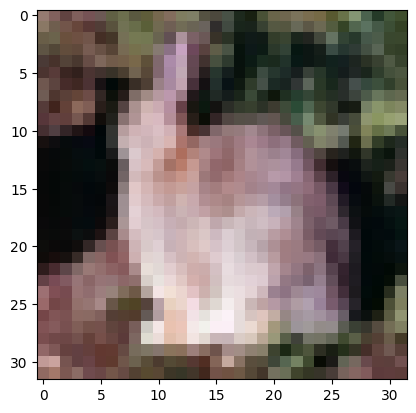

In [4]:
# get an sample from test set
test_img, gt, idx = dataset_test[5783]
# idx 9 : apples[0]
# idx 909: mushrooms[51]

# plot selected image
# class 0 -> 'Apples'

test_img_plot = ConvertToPlotableImage(test_img,MEAN_PIX=[0.5071, 0.4867, 0.4408],STD_PIX=[0.2675, 0.2565, 0.2761])
plt.imshow(test_img_plot)
print('Image Index: {}, GT: {} = {}'.format(idx, gt, CIFAR100_Fine_labels[gt]))

# add fake mini-batch dimension: [3x32x32] -> [1x3x32x32, and put in gpu mem
test_img1 = test_img.unsqueeze(0).to(device)

In [7]:
# all weight checkpoints for cifar100 pretrains
weight_files = [
    #'WRN-16-1_from-scratch_CIFAR-100_pretrains_240epochs_ValAcc:67.86_2023-07-28.pth',
    #'WRN-16-2_from-scratch_CIFAR-100_pretrains_240epochs_ValAcc:73.45_2023-07-28.pth',
    #'WRN-16-4_from-scratch_CIFAR-100_pretrains_240epochs_ValAcc:76.91_2023-07-28.pth',
    #'WRN-40-1_from-scratch_CIFAR-100_pretrains_240epochs_ValAcc:71.31_2023-07-28.pth',
    #'WRN-40-2_from-scratch_CIFAR-100_pretrains_240epochs_ValAcc:76.68_2023-07-28.pth', 
    'WRN-40-4_from-scratch_CIFAR-100_pretrains_240epochs_ValAcc:79.16_2023-07-28.pth',
    'ResNet-18_from-scratch_CIFAR-100_pretrains_350epochs_ValAcc:78.13_2023-08-22.pth',
    'ResNet-110_from-scratch_CIFAR-100_pretrains_350epochs_ValAcc:74.61_2023-08-01.pth',
    'MobileNetV2_x1_0_from-scratch_CIFAR-100_pretrains_240epochs_ValAcc:69.66_2023-08-28.pth',
    #'MobileNetV2_x0_5_from-scratch_CIFAR-100_pretrains_240epochs_ValAcc:65.87_2023-08-28.pth'
]

Evaluating on cifar100 test set...


100%|█████████████████████████████████████████████| 79/79 [00:01<00:00, 48.81it/s]


Evaluating on cifar100 test set...


100%|████████████████████████████████████████████| 79/79 [00:00<00:00, 104.47it/s]


Evaluating on cifar100 test set...


100%|█████████████████████████████████████████████| 79/79 [00:00<00:00, 88.97it/s]


6 1
Evaluating on cifar100 test set...


100%|████████████████████████████████████████████| 79/79 [00:00<00:00, 131.99it/s]


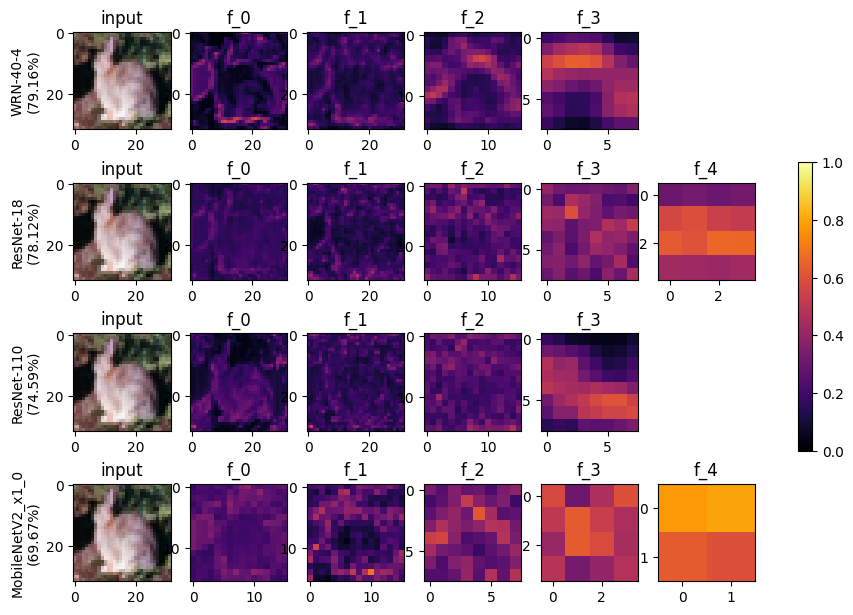

In [27]:
# compute attention maps from first 4 activation tensors
fig, axs = plt.subplots(len(weight_files), 6, figsize=(11,7.5))


for i in range(len(weight_files)):

    # get model 
    weight_file = weight_files[i]
    stringbits = weight_file.split('_')
    model_name = stringbits[0]
    if model_name == 'MobileNetV2':
        model_name = model_name + '_' + stringbits[1] + '_' + stringbits[2]
    
    model = get_Model(model_name,100)
    model.to(device)

    # load cifar100 pretrain weigh
    model.load_state_dict(torch.load(os.path.join('/home/chitraz/Documents/UoS_MSc/EEEM056_Project/Experiments/saves',weight_file)))
    
    # get test accuracy 
    print('Evaluating on cifar100 test set...')
    test_acc = evaluate(model, device, dataloader_test,NUM_CLASS=100, ConfMatrix = False)
    #print('{}: cifar100 test accuarcy => {} %'.format(model_name, test_acc))

    # feedforward the pre-trained model to get intermediate activation tensors and logit
    with torch.no_grad():
        feats, logits= model(test_img1, is_feat=True, preact=False)

    # plot input image and the four attention maps
    for j in range(len(feats)): 
        if j==0:
            axs[i,j].imshow(test_img_plot)
            axs[i,j].set_title('input')
            axs[i,j].set_ylabel('{}\n({}%)'.format(model_name, test_acc))
        else:
            map = at_map(feats[j-1])
            im = axs[i,j].imshow(map.squeeze(0).cpu(), cmap='inferno', vmin=0, vmax=1)
            axs[i,j].set_title('f_{}'.format(j-1))

    

axs[0,5].set_visible(False)
axs[2,5].set_visible(False)
fig.figure.colorbar(im, ax = axs, shrink=0.5 )


In [15]:
model_name

'MobileNetV2_x1_0'